# Chapter 7 - Combining different models for Ensemble Learning

Thegoal of ensemble methods is to combined different classifiers into a meta-classifier that has better generalization performance than each individual classifier alone.

The most popular ensemble methods use majority voting --> selects the class label that has been predicted by the majority of classifiers. Strictly speaking majority voting only refers to binary-class settings, in multiclass problems it is called plurality voting.

Ensembles can use the same base classification algorithm (random forest for decision trees), or use multiple.

Formula -> ^y = mode{C1(x), C2(x), ..., Cm(x)}

In [1]:
%time
from scipy.special import comb
import math

#Formula to prove that the error rate of ensemble methods with number of classifier n 
#decrease with an increasing number of classifiers.
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) *
            error ** k *
            (1-error)**(n_classifier - k)
            for k in range(k_start, n_classifier+ 1)]
    return sum(probs)

ensemble_error(n_classifier=11, error = 0.25)

Wall time: 0 ns


0.03432750701904297

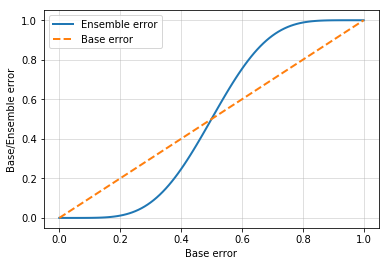

In [7]:
import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0, 1.01, 0.01)
ens_error = [ensemble_error(n_classifier = 11, error = error) for error in error_range]
plt.plot(error_range, ens_error,
        label = 'Ensemble error', linewidth = 2)
plt.plot(error_range, error_range,
        label = 'Base error', linestyle = '--', linewidth = 2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.grid(alpha=0.5)
plt.legend(loc = 'upper left')
plt.show()

The above plot proves that an ensemble method always outperforms a single classifier as long as the base-classifier performs better than random guessing (error < 0.5)

## Combining classifiers via majority vote
The algorithm we are about to implement will alow us to combine different classification algorithms associated with individual weights for confidence


In [6]:
#Weighted majority vote
import numpy as np
np.argmax(np.bincount([0,0,1], weights = [0.2,0.2,0.6]))

1

In [8]:
#Weighte majority vote based on class probablities (not on classes only)
ex = np.array([[0.9, 0.1],
              [0.8, 0.2],
              [0.4, 0.6]])
p = np.average(ex, axis = 0, weights = [0.2, 0.2, 0.6])
print(p)
np.argmax(p)

[0.58 0.42]


0

In [39]:
#Implementation of MajorityVoteClassifier
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator,
                            ClassifierMixin):
    """A majority vote ensemble classifier
    
    Parameters
    -----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble
      
    vote : str, { 'classlabel', 'probability'}
      Default: 'classlabel'
      If 'classlabel' the prediction is based on the argmax of class labels. Else if 
      'probability', the argmax of the sum of probabilities is used to predict the class label
      (recommended for calibrated classifiers)
      
    weights : array-like, shape = [n_classifiers]
      Optional, default: None
      If a list of 'int' or 'float' values are provided, the classifiers are weighted by
      importances; Uses uniform weights if 'weights = None'
      
    """
    
    def __init__(self, classifiers,
                vote = 'classlabel', weights = None):
        
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    
    def fit(self, X, y):
        """Fit classifiers.
        
        Parameters
        -----------
        X: {array-like, sparse matrix},
           shape = [n_samples, n_features]
           Matrix of training samples.
        
        y : array-like, shape = [n_samples]
           Vector of target class labels.
           
        Returns
        --------
        self : object
        
        """
        #Use LabelEncoder to ensure class labels start with 0, which is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,
                                       self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self,X):
        """Predict class labels for X.
        
        Parameters
        -----------
        X : {array-like, sparse matrix},
            Shape = [n_samples, n_features]
            Matrix of training samples
        
        Returns
        --------
        maj_vote : array-like, shape = [n_samples]
           Predicted class labels
           
        """
        
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis = 1)
        else: #'classlabel' vote
            #Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights = self.weights)), axis = 1, arr = predictions)
        
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self,X):
        """Predict class probabilities for X.
        
        Parameters
        -----------
        X : {array-like, sparse matrix},
           shape = [n_samples, n_features]
           Training vectors, where n_samples is the number of samples and n_features is the number of features
           
        Returns
        --------
        avg_proba : array-like,
           shape = [n_samples, n_classes]
           Weighted average probability for each class per sample
           
        """
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis = 0, weights = self.weights)
        
        return avg_proba
    
    def get_params(self, deep = True):
        """Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep = False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep = True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [40]:
#Implementing on 2 features of the Iris dataset
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:] #Select example 50-150, so only 2 classes
le = LabelEncoder() #Initiate labelencoder for encoding cLasses to 0 and 1
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 1, stratify = y)


In [41]:
#Using the dataset, we now will train three different classifiers: LR, Decision tree and KNN
#Evaluation is done via 10-fold cross-validation on the training dataset before combining into an ensemble

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty = 'l2', C= 0.001, random_state = 1)
clf2 = DecisionTreeClassifier(max_depth = 1, criterion = 'entropy', random_state = 0)
clf3 = KNeighborsClassifier(n_neighbors = 1, p = 2, metric = 'minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
#Pipe 2 not necessary as decision trees are not influenced by scale-abnormalities
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator = clf,
                            X = X_train,
                            y = y_train,
                            cv = 10,
                            scoring = 'roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


In [42]:
#Implement our MajorityClassVoter
mv_clf = MajorityVoteClassifier(classifiers = [pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator = clf,
                            X = X_train,
                            y = y_train,
                            cv = 10,
                            scoring = 'roc_auc')
    print('Accuracy: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

Accuracy: 0.87 (+/- 0.17) [Logistic regression]
Accuracy: 0.89 (+/- 0.16) [Decision tree]
Accuracy: 0.88 (+/- 0.15) [KNN]
Accuracy: 0.94 (+/- 0.13) [Majority voting]


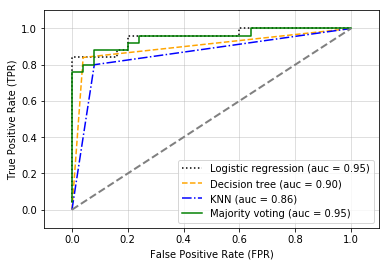

In [43]:
#Evaluating and tuning the ensemble classifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    #assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred)
    
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
            color = clr,
            linestyle = ls,
            label = '%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0,1], [0,1],
        linestyle = '--',
        color = 'gray',
        linewidth = 2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha = 0.5)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

C:\Users\rikkr\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


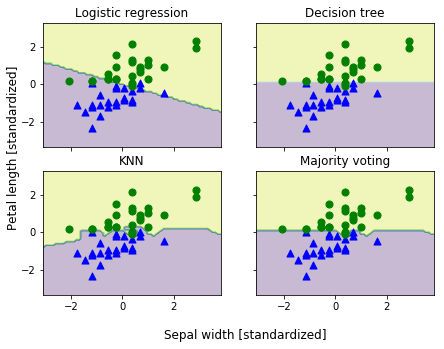

In [44]:
#Plot decisionregions
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:,0].min() - 1
x_max = X_train_std[:,0].max() + 1
y_min = X_train_std[:,1].min() - 1
y_max = X_train_std[:,1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows = 2, ncols = 2,
                       sharex = 'col', 
                       sharey = 'row',
                       figsize = (7,5))
for idx, clf, tt in zip(product([0,1], [0,1]),
                       all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0],
                                 X_train_std[y_train == 0, 1],
                                 c = 'blue', 
                                 marker = '^',
                                 s = 50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 1, 0],
                                 X_train_std[y_train == 1, 1],
                                 c = 'green', 
                                 marker = 'o',
                                 s = 50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.5, s = 'Sepal width [standardized]',
        ha = 'center', va = 'center', fontsize = 12)
plt.text(-12.5, 4.5, s = 'Petal length [standardized]',
        ha = 'center', va = 'center', fontsize = 12, rotation = 90)
plt.show()

In [45]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'pipeline-2': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=No

In [48]:
#Grid search of depth decisiontreeclassifier and C in LR-classifier. 
#Take the parameter names just discovered using the get_params_
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth' : [1,2],
         'pipeline-1__clf__C' : [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator = mv_clf,
                   param_grid = params,
                   cv = 10, 
                   scoring = 'roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [49]:
for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f+/-%0.2f %r" % (mean_score, scores.std() / 2, params))

0.933+/-0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.947+/-0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.973+/-0.03 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.947+/-0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.947+/-0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.973+/-0.03 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


C:\Users\rikkr\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [50]:
print('Best parameters: %s' %grid.best_params_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}


In [51]:
print('Accuracy: %.2f' %grid.best_score_)

Accuracy: 0.97


# Bagging - building an ensemble of classifiers from bootstrap samples

Bagging (or bootstrap aggregating) is a technique similar to Majority voting. However in bagging the invidividual classifier each draw a bootstrap sample (random samples with replacement) from the initial training set

In [53]:
#Applying bagging to classify samples in the Wine dataset
import pandas as pd
df_wine = pd.read_csv('Https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header = None)
df_wine.columns = ['Class label', 'Alcohol',
                  'Malic acid', 'Ash',
                  'Alcalinity of Ash', 'Magnesium', 
                  'Total phenols', 'Flavanoids', 
                  'Nonflavanoid phenols', 'Proanthocyanins', 
                  'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 
                  'Proline']
#drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [54]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)

In [58]:
#Bagging classifier is already implemented in scikit-learn
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 1, max_depth = None)
bag = BaggingClassifier(base_estimator = tree,
                      n_estimators = 500,
                      max_samples = 1.0,
                      max_features = 1.0,
                      bootstrap = True,
                      bootstrap_features = False,
                      n_jobs = -1,
                      random_state = 1)

In [59]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


In [62]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.917


As seen above, both score 100% on train set, but bagging is better gerenalizable as test performance is better

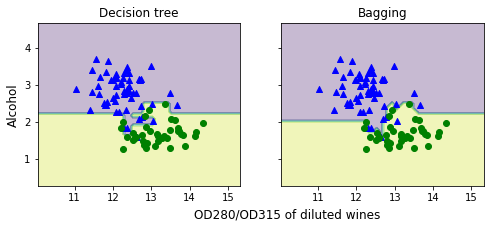

In [79]:
#plot decision regions
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows = 1, ncols = 2,
                       sharex = 'col',
                       sharey = 'row',
                       figsize = (8,3))

for idx, clf, tt in zip([0,1],
                       [tree, bag],
                       ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                      X_train[y_train == 0, 1],
                      c = 'blue', marker = '^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                      X_train[y_train == 1, 1],
                      c = 'green', marker = 'o')
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol', fontsize = 12)
plt.text(10.2, -0.5,
        s = 'OD280/OD315 of diluted wines',
        ha = 'center', va = 'center', fontsize = 12)
plt.show()

# Adaptive boosting

Boosting uses a simple base classifier (also weak learner), focus on examples that are hard to classifiy, and let the weak learners subsequently leran from misclassified training samples.

Steps:
* 1) Draw a random subset of training samples d1 without replacement from trainign set D to train a weak learner C1
* 2) Draw a second random training subset d2 without replacement from the training set and add 50 percent of the samples that were previously misclasified to train a weak learner C2.
* 3) Find the training samples d3 in training set D, which C1 and C2 disagree upon, to train a third weak learner C3.
* 4) Combine the weak learners C1, C2 and C3 via majority voting.\

NOTE: In contrast to original boosting procedure, adaptive boosting uses the complete training set to train the weak learners where the training samples are reweighted in each iteration to build a strong classifier that learns from the mistakes of the previous weak learners in the ensemble.

In [81]:
#Applying AdaBoost using scikit-learn
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion = 'entropy',
                             random_state = 1,
                             max_depth = 1)
ada = AdaBoostClassifier(base_estimator = tree,
                        n_estimators = 500,
                        learning_rate = 0.1,
                        random_state = 1)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies: %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies: 0.916/0.875


In [83]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies: %.3f/%.3f' % (ada_train, ada_test))

AdaBoost train/test accuracies: 1.000/0.917


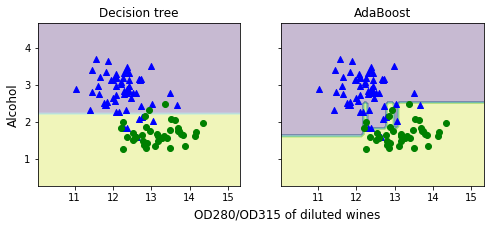

In [84]:
#plot decision regions
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows = 1, ncols = 2,
                       sharex = 'col',
                       sharey = 'row',
                       figsize = (8,3))

for idx, clf, tt in zip([0,1],
                       [tree, ada],
                       ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                      X_train[y_train == 0, 1],
                      c = 'blue', marker = '^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                      X_train[y_train == 1, 1],
                      c = 'green', marker = 'o')
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol', fontsize = 12)
plt.text(10.2, -0.5,
        s = 'OD280/OD315 of diluted wines',
        ha = 'center', va = 'center', fontsize = 12)
plt.show()

Last NOTE: boosting is computationally expensive and therefore it should be considered if it is worth it and feasible for real-world applications